In [1]:
import datetime
from dateutil import parser
import pytz
from timezonefinder import TimezoneFinder

import numpy as np
import scipy.signal as signal
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt

import time, sys
import re

import xml.etree.ElementTree as ET
import bs4 as bs
import urllib.request
from selenium import webdriver

from multiprocessing import Pool, cpu_count

start_time = time.time()
    
#%matplotlib inline
#https://github.com/MrMinimal64/timezonefinder

utc=pytz.UTC

#debug = True
debug = True
filepath = './sample_data/'

if debug == False:
    gpx_file = input('Enter file name (must be in same directory as this program for now): ')
    tree = ET.parse(filepath + gpx_file)
else:
    tree = ET.parse('./sample_data/Exciter_100.gpx')
    #tree = ET.parse('./sample_data/ITPS_out.gpx')
    #tree = ET.parse('./sample_data/See_you_later_Winter_welcome_Spring.gpx')
root = tree.getroot()

In [2]:
def namespace(element):
    m = re.match('\{(.*)\}', element.tag)
    return m.group(1) if m else ''

#namespace = {'gpx':'http://www.topografix.com/GPX/1/1'}
namespace = {'gpx':namespace(root)}

#helper functions
def deg2rad(x):
    return x * np.pi / 180

def rad2deg(angle):
    return angle * 180 / np.pi

def kt2ms(speed):
    return speed * 0.5144444

def ms2kmh(speed):
    return speed * 3.6

def kmh2kt(speed):
    return speed / 1.852

In [3]:
def get_dist_trk(p2, p1):
    #p1 is a list with lat and long in degrees
    #p2 is also a list: lat long
    #returns distance and angle
    #distance in metres
    #reference: https://www.movable-type.co.uk/scripts/latlong.html
    R = 6371e3 #mean radius of Earth in meters
    phi1 = deg2rad(p1[0])
    phi2 = deg2rad(p2[0])
    lambda1 = deg2rad(p1[1])
    lambda2 = deg2rad(p2[1])
    delta_phi = phi2 - phi1
    delta_lambda = lambda2 - lambda1
    a = np.sin(delta_phi / 2) * np.sin(delta_phi / 2) + \
        np.cos(phi1) * np.cos(phi2) * \
        np.sin(delta_lambda / 2) * np.sin(delta_lambda / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    y = np.sin(delta_lambda) * np.cos(phi2)
    x = np.cos(phi1) * np.sin(phi2) - \
        np.sin(phi1) * np.cos(phi2) * np.cos(delta_lambda)
    brg = np.arctan2(y,x) * 180 / np.pi
    return d, brg + 180

In [4]:
def get_dist_trk(p2, p1):
    #p1 is a list with lat and long in degrees
    #p2 is also a list: lat long
    #returns distance and angle
    #distance in metres
    #reference: https://www.movable-type.co.uk/scripts/latlong.html
    R = 6371e3 #mean radius of Earth in meters
    phi1 = deg2rad(p1[0])
    phi2 = deg2rad(p2[0])
    lambda1 = deg2rad(p1[1])
    lambda2 = deg2rad(p2[1])
    delta_phi = phi2 - phi1
    delta_lambda = lambda2 - lambda1
    a = np.sin(delta_phi / 2) * np.sin(delta_phi / 2) + \
        np.cos(phi1) * np.cos(phi2) * \
        np.sin(delta_lambda / 2) * np.sin(delta_lambda / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    y = np.sin(delta_lambda) * np.cos(phi2)
    x = np.cos(phi1) * np.sin(phi2) - \
        np.sin(phi1) * np.cos(phi2) * np.cos(delta_lambda)
    brg = np.arctan2(y,x) * 180 / np.pi
    return d, brg + 180

In [8]:
def get_trk_pts_data(trksegmt):
    '''
    function to generate track data
    input: list of tracksegments
    
    output: dataframe containing track data
    '''
    trackpoint = {}
    track = pd.DataFrame(columns=['lat', 'lon', 'elev', 'ts', 'dist', 'true_hdg', 'gs', 'delta_t', 'delta_elev'])
    first_point = True
    debug_counter = 0
    for idx, trkpoint in enumerate(trksegmt):
        trackpoint['lat'] = float(trkpoint.get('lat'))
        trackpoint['lon'] = float(trkpoint.get('lon'))
        for elev in trkpoint.findall('gpx:ele', namespace):
            #print(elev.text)
            trackpoint['elev'] = float(elev.text)
        for ts in trkpoint.findall('gpx:time', namespace):
            #print(ts.text)
            trackpoint['ts'] = parser.parse(ts.text)
        if first_point:
            previous_point = trackpoint
            first_point = False
        #dist, angle = get_dist_trk([previous_point['lat'],previous_point['lon']], [trackpoint['lat'],trackpoint['lon']])
        if debug_counter < 20:
            #print(dist, trackpoint['lon'], previous_point['lon'])
            debug_counter += 1

        trackpoint['delta_t'] = (trackpoint['ts']-previous_point['ts']).total_seconds()
        #trackpoint['dist'] = dist
        #trackpoint['true_hdg'] = angle
        #if trackpoint['delta_t'] != 0:
        #    trackpoint['gs'] = dist / trackpoint['delta_t']
        #else:
        #    trackpoint['gs'] = 0
        #    trackpoint['delta_t'] = np.nan
        trackpoint['delta_elev'] = (trackpoint['elev']-previous_point['elev'])
        previous_point = trackpoint
        track = track.append(trackpoint, ignore_index=True)
        trackpoint = {}
    return track

In [9]:
print('Building track database...')
track = pd.DataFrame(columns=['lat', 'lon', 'elev', 'ts', 'dist', 'true_hdg', 'gs', 'delta_t', 'delta_elev'])
#lat in deg decimal
#lon in deg decimal
#elev in meters
#ts in datetime, tz=0
#dist in meters
#true_hdg in degrees
#gs in m/s

debug_counter = 0
n_proc = cpu_count() #number of multiprocesses in pool

for trk in root.findall('gpx:trk', namespace):
    for trksegmt in trk.findall('gpx:trkseg', namespace):
        first_point = True
        trkpoints = trksegmt.findall('gpx:trkpt', namespace)
        trk_pts_number = len(trkpoints)
        trk_pts_set = []
        
        for i in range(n_proc):
            if i < (n_proc - 1):
                trk_pts_set.append(trkpoints[int(trk_pts_number / n_proc) * (i):(int(trk_pts_number / n_proc) * (i+1) -1)])
            else:
                trk_pts_set.append(trkpoints[int(trk_pts_number / n_proc) * (i):trk_pts_number])
            
        #get_trk_pts_data(trk_pts_set[0])
        n_proc
        pool = Pool(n_proc)
        #map guarantees the order back
        results = pool.map(get_trk_pts_data, trk_pts_set)
        pool.join
        #join results:
        track = pd.DataFrame(columns=['lat', 'lon', 'elev', 'ts', 'dist', 'true_hdg', 'gs', 'delta_t', 'delta_elev'])
        for result in results:
            track = track.append(result.set_index('ts'))
        track['ts'] = track.index
        track.reset_index(inplace=True, drop=True)       
        pool.terminate
        pool.close()

end_time = time.time()
print()
print('Track build time was {:1.1f} seconds'.format(end_time - start_time))

Building track database...

Track build time was 276.0 seconds


In [10]:
track.head()

,lat,lon,elev,ts,dist,true_hdg,gs,delta_t,delta_elev
0,43.026372,-81.269634,256.2,2020-05-16 12:23:20+00:00,NaN,NaN,NaN,0.0,0.0
1,43.026372,-81.269634,256.2,2020-05-16 12:23:21+00:00,NaN,NaN,NaN,1.0,0.0
2,43.026372,-81.269634,256.2,2020-05-16 12:23:22+00:00,NaN,NaN,NaN,1.0,0.0
3,43.026372,-81.269634,256.2,2020-05-16 12:23:23+00:00,NaN,NaN,NaN,1.0,0.0
4,43.026372,-81.269634,256.2,2020-05-16 12:23:24+00:00,NaN,NaN,NaN,1.0,0.0


In [11]:
#from https://stackoverflow.com/questions/45840118/how-do-i-calculate-speed-from-a-gpx-file-if-the-speed-tag-itself-is-not-given
r = 6371000 # meters
track['theta'] = np.deg2rad(track['lon'])
track['phi'] = np.deg2rad(track['lat'])
track['x'] = r*np.cos(track['theta'])*np.sin(track['phi'])
track['y'] = r*np.sin(track['theta'])*np.sin(track['phi'])
track['z'] = r*np.cos(track['phi'])

In [12]:
track['x2'] = track['x'].shift()
track['y2'] = track['y'].shift()
track['z2'] = track['z'].shift()
track['dist'] = np.sqrt((track['x2']-track['x'])**2 + (track['y2']-track['y'])**2 + (track['z2']-track['z'])**2)

In [13]:
track['central angle'] = np.arccos((track['x']*track['x2'] + track['y']*track['y2'] + track['z']*track['z2'])/r**2)
track['arclength'] = track['central angle']*r

/home/wall-e/miniconda3/envs/gpx1/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
track['time'] = (track['ts'].diff() / pd.Timedelta(seconds=1))

In [16]:
track['gs'] = track['arclength'] / track['time']  # in meters/second

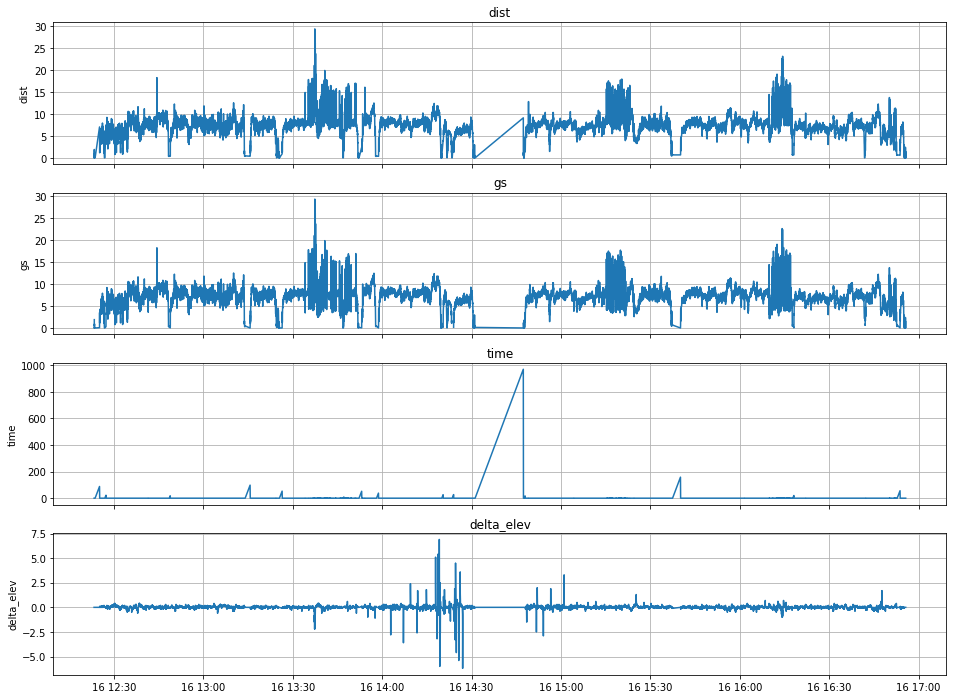

In [17]:
plt_list = ['dist', 'gs', 'time', 'delta_elev']
plt.rcParams['figure.figsize'] = [16, 12]
f, axarr = plt.subplots(len(plt_list), sharex=True)
for idx, pltdata in enumerate(plt_list):
    axarr[idx].plot((track['ts']),track[pltdata])
    axarr[idx].set(ylabel=pltdata,
       title=pltdata)
    axarr[idx].grid()

#fig.savefig("test.png")
plt.show()